Todo:
- optimize filtering results
- combinded routine hyperopt+gd
- look at toffoli4 with ancilla
- look at 14-gate 5 qubits circuits
- estimate failure % for 5-qubuts toffoli
- look what is best 5-toffoli on chain

What could give more speedup:
- Simpler cost function? Like Re Tr?
- Stopping learning at reached target accuracy?
- Better (smoothened) penalty function?

Issues to fix:
- Change random seeds in objective function.

In [1]:
from jax_circuits import *
from topology import *
from penalty import *
from cp_utils import *
import matplotlib.pyplot as plt
from scipy.stats import unitary_group
from qiskit import transpile
from qiskit.quantum_info import Operator
# import pickle
# import dill
# import time

# import hyperopt
# from hyperopt import  hp, fmin, tpe, Trials, STATUS_OK

# import hyperopt.pyll.stochastic
# from hyperopt.pyll import scope

# Adaptive decompose

In [ ]:
hyperopt_options = {'max_num_cp_gates': 20,
                    'accepted_num_gates': 10,
                    'target_num_gates': 8,
                    'num_gd_iterations': 2000,
                    'batch_size': 100,
                    'evals_between_verification': 2,
                    'max_evals': 5,
                   }

trials, decompositions = adaptive_decompose(u_toff3, 
                        chain_layer(3), 
                        hyperopt_options, 
                        save_to='data/toff3_chain', 
                        overwrite_existing=True)

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]

In [8]:
trials.losses()

[-0.4000000059604645,
 -0.30000001192092896,
 -0.20000000298023224,
 -0.0,
 -0.10000000149011612,
 -0.30000001192092896,
 -0.20000000298023224,
 -0.30000001192092896,
 -0.20000000298023224,
 -0.0,
 -0.20000000298023224,
 -0.0,
 -0.0,
 -0.20000000298023224,
 -0.30000001192092896,
 -0.0,
 -0.15000000596046448,
 -0.10000000149011612,
 -0.23999999463558197,
 -0.09000000357627869,
 -0.009999999776482582,
 -0.30000001192092896,
 -0.009999999776482582,
 -0.15000000596046448,
 -0.07000000029802322,
 -0.10000000149011612,
 -0.14000000059604645,
 -0.03999999910593033,
 -0.09000000357627869,
 -0.15000000596046448,
 -0.1599999964237213,
 -0.05000000074505806]

In [3]:
len(trials.trials)

32

In [9]:
trials.trials[0]

{'state': 2,
 'tid': 0,
 'spec': None,
 'result': {'loss': -0.4000000059604645,
  'status': 'ok',
  'angles_random_seed': 657251,
  'cz_counts': [8, 8, 8, 8, 9, 9, 9, 10, 11, 11],
  'num_gd_iterations': 2000,
  'entry_loss': 0.001,
  'threshold_cp': 0.2},
 'misc': {'tid': 0,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'num_cp_gates': [0], 'r': [0]},
  'vals': {'num_cp_gates': [16.0], 'r': [0.0004403706688235234]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2022, 2, 15, 15, 58, 54, 41000),
 'refresh_time': datetime.datetime(2022, 2, 15, 15, 59, 11, 788000)}

In [10]:
best

{'num_cp_gates': 16.0, 'r': 0.0004403706688235234}

In [8]:
best

{'num_cp_gates': 16.0, 'r': 0.0004403706688235234}

# Hyperopt examples

In [57]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

num_samples=50

def objective(args):
    r, num_gates = args
    anz = Ansatz(3, 'cp', placements=fill_layers(chain_layer(3), num_gates))
    reg_options = {'r': r,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'accepted_num_gates': 12,
               'target_num_gates': 8,
               'cp_mask': anz.cp_mask}
    
    score, cz_counts = cp_ansatz_score(u_toff3, 
                                       anz, 
                                       reg_options, 
                                       num_samples=num_samples,
                                       save_prospective_results=False,
                                       save_raw_results=False,
                                       cp_dist='0')
    
    return {
        'loss': -score,
        'status': STATUS_OK}

In [58]:
space = [hp.loguniform('r', jnp.log(0.0001), jnp.log(0.01)),
        scope.int(hp.quniform('num_gates', 1, 30, 1))]

samples = [hyperopt.pyll.stochastic.sample(space) for _ in range(100)] 
r_samples = [r for r,_ in samples]
g_samples = [g for _,g in samples]

# plt.xscale('log')
# plt.hist(r_samples)

In [59]:
trials = Trials()
best = fmin(objective,
    space=space,
    algo=tpe.suggest,
    max_evals=150,
    trials=trials)

print(best)

100%|██████████| 150/150 [1:09:03<00:00, 27.62s/trial, best loss: -16.0625]
{'num_gates': 21.0, 'r': 0.0005310848219253889}


In [92]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

anz = Ansatz(3, 'cp', fill_layers(chain_layer(3), 21))

reg_options = {'r': 0.0005310848219253889,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'target_num_gates': 8,
               'accepted_num_gates': 7,
               'angle_tolerance': 0.2,
               'cp_mask': anz.cp_mask}

key = random.PRNGKey(2)
num_samples = 100

successful_results, failed_results = cp_decompose(u_toff3, 
                                               anz,
                                               regularization_options=reg_options,
                                               num_samples=num_samples, 
                                               key=key,
                                               disc_func=disc2,
                                               cp_dist='0',
                                               save_raw_results=True,
                                               save_to='data/toff3_chain')


Computing raw results.

Selecting prospective results:


100it [00:01, 68.35it/s]


0 found.

Verifying prospective results:


0it [00:00, ?it/s]

0 successful.
cz counts are:
[]


In [93]:
with open('data/toff3_chain_raw_results.pickle', 'rb') as f:
    raw_results = pickle.load(f)

In [96]:
filter_cp_results(raw_results, anz.cp_mask, 0.2, 1e-4)

100it [00:01, 73.34it/s]


[]

In [61]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

num_samples=50

def objective(args):
    r, num_gates = args
    anz = Ansatz(3, 'cp', placements=fill_layers(chain_layer(3), num_gates))
    reg_options = {'r': r,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'accepted_num_gates': 12,
               'target_num_gates': 8,
               'cp_mask': anz.cp_mask}
    
    score, cz_counts = cp_ansatz_score(u_toff3, 
                                       anz, 
                                       reg_options, 
                                       num_samples=num_samples,
                                       save_prospective_results=False,
                                       save_raw_results=False,
                                       cp_dist='uniform')
    
    return {
        'loss': -score,
        'status': STATUS_OK}

space = [hp.loguniform('r', jnp.log(0.0001), jnp.log(0.01)),
        scope.int(hp.quniform('num_gates', 1, 30, 1))]

trials = Trials()
best = fmin(objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials)

print(best)

100%|██████████| 100/100 [42:08<00:00, 25.28s/trial, best loss: -25.25] 
{'num_gates': 13.0, 'r': 0.000644899814208608}


In [11]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

anz = Ansatz(3, 'cp', fill_layers(chain_layer(3), 13))

reg_options = {'r': 0.0002510848219253889,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'target_num_gates': 8,
               'accepted_num_gates': 8,
               'angle_tolerance': 0.2,
               'cp_mask': anz.cp_mask}

key = random.PRNGKey(5)
num_samples = 100

successful_results, failed_results = cp_decompose(u_toff3, 
                                               anz,
                                               regularization_options=reg_options,
                                               num_samples=num_samples, 
                                               key=key,
                                               disc_func=disc2,
                                               cp_dist='uniform',
                                               save_to='toff3_connected')


Computing raw results.

Selecting prospective results:


100it [00:01, 89.37it/s]


13 found.

Verifying prospective results:


100%|██████████| 13/13 [04:39<00:00, 21.51s/it]


13 successful.
cz counts are:
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]


In [2]:
qc = QuantumCircuit(4)
qc.mct([0, 1, 2], 3)
u_toff4 = Operator(qc.reverse_bits()).data

num_samples=200

def objective(args):
    r, num_gates = args
    anz = Ansatz(4, 'cp', placements=fill_layers(chain_layer(4), num_gates))
    reg_options = {'r': r,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'accepted_num_gates': 25,
               'target_num_gates': 18,
               'cp_mask': anz.cp_mask}
    
    score, cz_counts = cp_ansatz_score(u_toff4, 
                                       anz, 
                                       reg_options, 
                                       num_samples=num_samples,
                                       save_prospective_results=False,
                                       save_raw_results=False,
                                       cp_dist='uniform')
    
    return {
        'loss': -score,
        'status': STATUS_OK}

space = [hp.loguniform('r', jnp.log(0.00005), jnp.log(0.001)),
        scope.int(hp.quniform('num_gates', 15, 40, 1))]

trials = Trials()
best = fmin(objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials)

print(best)    

100%|██████████| 50/50 [1:39:57<00:00, 119.95s/trial, best loss: -1.2890625]
{'num_gates': 25.0, 'r': 0.0005908527276785403}


In [3]:
time_start = time.time()
qc = QuantumCircuit(4)
qc.mct([0, 1, 2], 3)
u_toff4 = Operator(qc.reverse_bits()).data


anz = Ansatz(4, 'cp', fill_layers(chain_layer(4), 25))

reg_options = {'r': 0.0005908527276785403,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'accepted_num_gates': 19,
               'target_num_gates': 18,
               'cp_mask': anz.cp_mask}

key = random.PRNGKey(131)

num_samples = 2000

successful_results, failed_results = cp_decompose(u_toff4, 
                                               anz,
                                               regularization_options=reg_options,
                                               num_samples=num_samples, 
                                               key=key,
                                               disc_func=disc2,
                                               cp_dist='uniform',
                                               save_to='toff4_chain')

print(f'time: {time.time()-time_start}')


Computing raw results.

Selecting prospective results:


2000it [00:39, 50.52it/s]


1 found.

Verifying prospective results:


100%|██████████| 1/1 [00:47<00:00, 47.34s/it]

1 successful.
cz counts are:
[18]
time: 1090.0114843845367


In [ ]:
qc = QuantumCircuit(5)
qc.mct([0, 1, 2, 3], 4)
u_toff5 = Operator(qc.reverse_bits()).data

num_samples=500

def objective(args):
    r, num_gates = args
    anz = Ansatz(5, 'cp', placements=fill_layers(sequ_layer(5), num_gates))
    reg_options = {'r': r,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'accepted_num_gates': 100,
               'target_num_gates': 36,
               'cp_mask': anz.cp_mask}
    
    score, cz_counts = cp_ansatz_score(u_toff5, 
                                       anz, 
                                       reg_options, 
                                       num_samples=num_samples,
                                       save_prospective_results=False,
                                       save_raw_results=False,
                                       cp_dist='uniform')
    
    return {
        'loss': -score,
        'status': STATUS_OK}

space = [hp.loguniform('r', jnp.log(0.00005), jnp.log(0.001)),
        scope.int(hp.quniform('num_gates', 15, 40, 1))]

trials = Trials()
best = fmin(objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials)

print(best)    

In [9]:
jnp.log(rmin)

DeviceArray(-9.903487, dtype=float32)

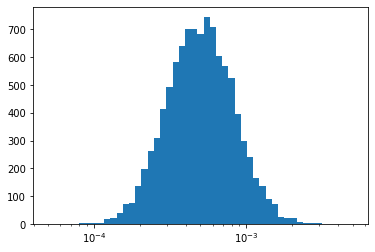

In [49]:
rmiddle = 0.0005

space = [hp.lognormal('r', jnp.log(rmiddle), 0.5),
        scope.int(hp.quniform('num_gates', 36, 60, 1))]


qc = QuantumCircuit(5)
qc.mct([0, 1, 2, 3], 4)
u_toff5 = Operator(qc.reverse_bits()).data

num_samples=500

def objective(args):
    r, num_gates = args
    anz = Ansatz(5, 'cp', placements=fill_layers(sequ_layer(5), num_gates))
    reg_options = {'r': r,
               'function': 'linear',
               'ymax': 2,
               'xmax': jnp.pi/2,
               'plato': 0.05,
               'accepted_num_gates': 100,
               'target_num_gates': 36,
               'cp_mask': anz.cp_mask}
    
    score, cz_counts = cp_ansatz_score(u_toff5, 
                                       anz, 
                                       reg_options, 
                                       num_samples=num_samples,
                                       save_prospective_results=False,
                                       save_raw_results=False,
                                       cp_dist='uniform')
    
    return {
        'loss': -score,
        'status': STATUS_OK}


trials = Trials()
best = fmin(objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials)

print(best)    

# samples = [hyperopt.pyll.stochastic.sample(space) for _ in range(10000)] 
# r_samples = [r for r,_ in samples]
# g_samples = [g for _,g in samples]


# logbins = jnp.e**jnp.linspace(jnp.log(rmiddle/10), jnp.log(rmiddle*10), 50)
# plt.hist(r_samples, bins=logbins)
# plt.xscale('log')

In [37]:
10**jnp.log(rmin)

DeviceArray(1.2488573e-10, dtype=float32)

In [38]:
rmin

5e-05

In [22]:
jnp.e**jnp.logspace(jnp.log(rmin), jnp.log(rmax), 4)

DeviceArray([1.       , 1.       , 1.       , 1.0000001], dtype=float32)

In [23]:
jnp.e

2.718281828459045

In [19]:
jnp.log(rmin)

DeviceArray(-9.903487, dtype=float32)

In [65]:
import pickle
import time
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

def objective(x):
    return {
        'loss': x ** 2,
        'status': STATUS_OK,
        # -- store other results like this
        'eval_time': time.time(),
        'other_stuff': {'type': None, 'value': [0, 1, 2]},
        # -- attachments are handled differently
        'attachments':
            {'time_module': pickle.dumps(time.time)}
        }
trials = Trials()
best = fmin(objective,
    space=hp.uniform('x', -10, 10),
    algo=tpe.suggest,
    max_evals=1000,
    trials=trials)

print(best)

100%|██████████| 1000/1000 [00:06<00:00, 157.81trial/s, best loss: 2.4546931171463713e-05]
{'x': -0.004954485964402736}


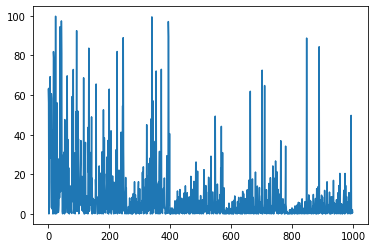

In [66]:
plt.plot([t['loss'] for t in trials.results])

In [79]:
qc = QuantumCircuit(6)
qc.mct([0,1,2,3,4],5)

qc_trans = transpile(qc, basis_gates=['cx', 'u'], optimization_level=3)

In [80]:
(qc_trans.qasm()).count('\ncx')

92

In [78]:
(qc.decompose().decompose().decompose().qasm()).count('\ncx')

36

In [77]:
qc.decompose().decompose().decompose().draw()

»
q_0: ────────────────────────────────────────────────────────────────────────»
                                                                             »
q_1: ────────────────────────────────────────────────────────────────────────»
                                                                             »
q_2: ────────────────────────────────────────────────────────────────────────»
     ┌──────────────┐                         ┌─────────────┐ ┌─────────────┐»
q_3: ┤ U3(0,0,-π/4) ├──■───────────────────■──┤ U3(π/2,0,π) ├─┤ U3(0,0,π/4) ├»
     ├─────────────┬┘┌─┴─┐┌─────────────┐┌─┴─┐├─────────────┴┐├─────────────┤»
q_4: ┤ U3(π/2,0,π) ├─┤ X ├┤ U3(0,0,π/4) ├┤ X ├┤ U3(0,0,-π/4) ├┤ U3(π/2,0,π) ├»
     └─────────────┘ └───┘└─────────────┘└───┘└──────────────┘└─────────────┘»
«                                                                            »
«q_0: ────────────────────────────────────────────────■──────────────────────»
«                                                     │                      »
«q_1: ────────────────────────────────────────────────┼───────────────────■──»
«                                                     │                   │  »
«q_2: ───────■────────────────────────────────────────┼───────────────────┼──»
«          ┌─┴─┐     ┌──────────────┐┌─────────────┐┌─┴─┐┌─────────────┐┌─┴─┐»
«q_3: ─────┤ X ├─────┤ U3(0,0,-π/4) ├┤ U3(π/2,0,π) ├┤ X ├┤ U3(0,0,π/4) ├┤ X ├»
«     ┌────┴───┴────┐└──────────────┘└─────────────┘└───┘└─────────────┘└───┘»
«q_4: ┤ U3(π/2,0,π) ├────────────────────────────────────────────────────────»
«     └─────────────┘                                                        »
«                                                                             »
«q_0: ──────────────────■─────────────────────────────────────────────────────»
«                       │                                                     »
«q_1: ──────────────────┼───────────────────■─────────────────────────────────»
«                       │                   │                                 »
«q_2: ──────────────────┼───────────────────┼─────────────────────────────────»
«     ┌──────────────┐┌─┴─┐┌─────────────┐┌─┴─┐┌──────────────┐┌─────────────┐»
«q_3: ┤ U3(0,0,-π/4) ├┤ X ├┤ U3(0,0,π/4) ├┤ X ├┤ U3(0,0,-π/4) ├┤ U3(π/2,0,π) ├»
«     └──────────────┘└───┘└─────────────┘└───┘└──────────────┘└─────────────┘»
«q_4: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«                                                                            »
«q_0: ───────────────────────────────────────────────────────────────────────»
«                                                                            »
«q_1: ───────────────────────────────────────────────────────────────────────»
«                                                                            »
«q_2: ─────────────────■─────────────────────────────────────────────────────»
«     ┌─────────────┐┌─┴─┐┌──────────────┐┌─────────────┐┌─────────────┐     »
«q_3: ┤ U3(0,0,π/4) ├┤ X ├┤ U3(0,0,-π/4) ├┤ U3(π/2,0,π) ├┤ U3(0,0,π/4) ├──■──»
«     └─────────────┘└───┘└──────────────┘└─────────────┘└─────────────┘┌─┴─┐»
«q_4: ──────────────────────────────────────────────────────────────────┤ X ├»
«                                                                       └───┘»
«                                                                     »
«q_0: ────────────────────────────────────────────────────────────────»
«                                                                     »
«q_1: ────────────────────────────────────────────────────────────────»
«                                                                     »
«q_2: ──────────────────────────────────────────────────────────■─────»
«                          ┌───────────────┐┌─────────────┐   ┌─┴─┐   »
«q_3: ──────────────────■──┤ U3(π/2,-2π,π) ├┤ U3(0,0,π/4) ├───┤ X ├───»
«     ┌───────